In [31]:
#  core
import pandas as pd
import numpy as np
import joblib
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# evaluation
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, balanced_accuracy_score
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data Analysis Pepeline:
1. Data Exploration
2. Data Cleaning
3. Feature Engineering
4. EDA (Visualisation)
5. Data Preprocessing (Scaling & Encoding)
6. Feature Selection
7. Modeling
8. Model Evaluation & Optimization
9. Deployment & Interpretation

# **STEP 1: Data Exploration**

## **Column Descriptions**

> Dataset Name: Kaggle Spaceship Titanic
- Objective: Predict whether passengers were transported to another dimension during the Spaceship Titanic incident.
- Problem Type: Binary Classification (Transported = True or False)

> Data Shape:
- Training Set: (8693 rows, 14 columns) → Contains both features and the Transported label.
- Test Set: (4277 rows, 13 columns) → Same features as training data, but without the Transported label.

> When converted into a Pandas DataFrame:

Transported (Target Variable)
- Type: Boolean (True or False)
- True = Passenger was transported
- False = Passenger was not transported
- Available only in the training set (train.csv).

PassengerId
- Unique identifier for each passenger (string, e.g., "0001_01").
- Used for submission matching.

HomePlanet
- The planet where the passenger started their journey (string).
- Categorical feature: examples include Earth, Europa, Mars.

CryoSleep
- Whether the passenger opted for cryogenic sleep during the voyage (boolean).
- Missing values may need to be handled.

Cabin
- Cabin identifier (string, format: deck/num/side, e.g., "B/123/S").
- Can be split into deck, number, and side for better feature engineering.

Destination
- Destination planet for the voyage (string).
- Common values: TRAPPIST-1e, 55 Cancri e, PSO J318.5-22.

Age
- Age of the passenger in years (float).
- May contain missing values.
- Often binned into age groups for modeling.

VIP
- Whether the passenger paid for special VIP service (boolean).
- Missing values present.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Amount spent on various amenities (float).
- Can have missing values; might be combined into a total spend feature.

Name
- Full name of the passenger (string).
- Can be split into first and last names if needed.

GroupId (optional, derived from PassengerId)
- Group number extracted from PassengerId ("0001" part).
- Useful to engineer group-based features.

## **Descriptive Statistics**

> Descriptive statistics summarize and describe the key features of a dataset.

In [2]:
# load the dataset
train = pd.read_csv('C:/Users/ARZ/Desktop/train.csv')
test = pd.read_csv('C:/Users/ARZ/Desktop/test.csv')

In [3]:
def dataset_snapshot(df):
    head = df.head(3)
    tail = df.tail(3)
    sample = df.sample(3)
    return pd.concat([head, tail, sample])

dataset_snapshot(train)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True
1207,1287_02,Mars,True,F/259/P,55 Cancri e,4.0,False,0.0,0.0,0.0,NaN,0.0,NaN,True
1916,2055_02,NaN,False,G/330/P,PSO J318.5-22,32.0,False,0.0,58.0,0.0,0.0,642.0,Sall Woodwinez,True
5930,6293_01,Earth,False,F/1301/P,TRAPPIST-1e,24.0,False,0.0,1049.0,1.0,0.0,0.0,Thel Sweekstarks,False


In [4]:
def quick_overview(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "nunique": df.nunique(),
        "missing": df.isnull().sum()
    }).reset_index().rename(columns={"index": "column"})
quick_overview(train)

,column,dtype,nunique,missing
0,PassengerId,object,8693,0
1,HomePlanet,object,3,201
2,CryoSleep,object,2,217
3,Cabin,object,6560,199
4,Destination,object,3,182
5,Age,float64,80,179
6,VIP,object,2,203
7,RoomService,float64,1273,181
8,FoodCourt,float64,1507,183
9,ShoppingMall,float64,1115,208


In [5]:
def check_df(df, target=None, head=3):
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 500)

    print("#################### SHAPE ########################")
    print(f"🔹 Rows: {df.shape[0]} | 🔹 Columns: {df.shape[1]}\n")
    
    print("#################### INFO #########################")
    print(df.info(), "\n")
 
    print("################## DESCRIPTIVE STATS (numerical) ##################")
    display(df.describe().T.style.background_gradient(cmap='PuBu'))
    
    print("################## DESCRIPTIVE STATS (categorical) ##################")
    display(df.describe(include='object').T.style.background_gradient(cmap='Oranges'))
    
    print("################## DUPLICATES ##################")
    print(f"🔁 Duplicate Rows: {df.duplicated().sum()}\n")

    if target and target in df.columns:
        print("############ TARGET DISTRIBUTION ############")
        print(df[target].value_counts(), "\n")

check_df(train, target= 'survived')

#################### SHAPE ########################
🔹 Rows: 8693 | 🔹 Columns: 14

#################### INFO #########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None 

#

,count,mean,std,min,25%,50%,75%,max
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000


################## DESCRIPTIVE STATS (categorical) ##################


,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


################## DUPLICATES ##################
🔁 Duplicate Rows: 0



In [6]:
def show_unique_categories(df):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        print(f"{col} ({df[col].nunique()} unique): {df[col].unique()[:5]}{'...' if df[col].nunique() > 5 else ''}")

show_unique_categories(train)

PassengerId (8693 unique): ['0001_01' '0002_01' '0003_01' '0003_02' '0004_01']...
HomePlanet (3 unique): ['Europa' 'Earth' 'Mars' nan]
CryoSleep (2 unique): [False True nan]
Cabin (6560 unique): ['B/0/P' 'F/0/S' 'A/0/S' 'F/1/S' 'F/0/P']...
Destination (3 unique): ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP (2 unique): [False True nan]
Name (8473 unique): ['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' 'Solam Susent'
 'Willy Santantines']...


# **STEP 2: Data Cleaning**

### **1️⃣Handle missing values**

In [7]:
# let's drop or fill missing values
for name, df in zip(['Train', 'Test'], [train, test]):
    missing = df.isnull().sum()[df.isnull().sum() > 0]
    if not missing.empty:
        print(f"\n{name} missing values:")
        print(missing)
    else:
        print(f"\n{name} has no missing values ✅")


Train missing values:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64

Test missing values:
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [8]:
# Fill Age with median
for df in [train,test]:
    df['Age'] = df['Age'].fillna(df['Age'].median())

In [9]:
# Fill categorical columns with mode
categorical_cols = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']
for df in [train,test]:
    for col in categorical_cols :
        df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
# Fill spending columns with 0
spending_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for df in [train,test]:
    for col in spending_cols :
        df[col] = df[col].fillna(0)

In [11]:
# Fill Cabin with 'Unknown/0/Unknown'
for df in [train,test]:
    df['Cabin'] = df['Cabin'].fillna('Unknown/0/Unknown')

In [12]:
# Fill Name if needed
for df in [train,test]:
    df['Name'] = df['Name'].fillna('Unknown')

In [13]:
print("🔍 Missing values in TRAIN set:")
print(train.isnull().sum()[train.isnull().sum() > 0])

print("\n🔍 Missing values in TEST set:")
print(test.isnull().sum()[test.isnull().sum() > 0])

🔍 Missing values in TRAIN set:
Series([], dtype: int64)

🔍 Missing values in TEST set:
Series([], dtype: int64)


### **2️⃣ Remove duplicates**

In [14]:
# sanity check for duplicated values 
train.duplicated().sum()
test.duplicated().sum()

0

### **3️⃣ Remove features**

In [15]:
# nothing to delete for now, we will delete some features after we extracted meaningful data in step 3

### **4️⃣ Fix incorrect/inconsistent data**

> Deals with wrong, inconsistent, or messy values (e.g., typos, inconsistent formats, leading/trailing spaces).

In [16]:
# Remove Leading/Trailing Spaces from Text Columns
for df in [train,test]:
    cat_columns = df.select_dtypes(include=['object']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.str.strip())

# **STEP 3: Feature Engineering**
- In this step, we create new meaningful features from existing data.

In [17]:
# cabin format: deck/number/side
# split in 3 new features

for df in [train,test]:
    df[['Deck','Cabin_num','Side']] = df['Cabin'].str.split('/',expand=True)
    # drop cabin feature
    df.drop('Cabin',axis=1, inplace=True)
train[['Deck','Cabin_num','Side']].value_counts()

for df in [train, test]:
    df['Cabin_num'] = pd.to_numeric(df['Cabin_num'], errors='coerce')

In [18]:
# # TotalSpending
spending_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for df in [train,test]:
    df['TotalSpending'] = df[spending_cols].sum(axis=1)

In [19]:
# AgeGroup
for df in [train,test]:
    df['AgeGroup'] = pd.cut(
        df['Age'], 
        bins=[-1,12,18,59,np.inf], 
        labels=['Child','Teenager','Adult','Senior']
    )
print(train['AgeGroup'].value_counts())
print(test['AgeGroup'].value_counts())

AgeGroup
Adult       6574
Teenager    1059
Child        806
Senior       254
Name: count, dtype: int64
AgeGroup
Adult       3258
Teenager     544
Child        351
Senior       124
Name: count, dtype: int64


In [20]:
# Group
for df in [train,test]:
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])

# GroupSize
for df in [train,test]:
    group_size = df['Group'].value_counts()
    df['GroupSize'] = df['Group'].map(group_size)

print(train[['PassengerId', 'Group', 'GroupSize']].head(10))
print(test[['PassengerId', 'Group', 'GroupSize']].head(10))

  PassengerId Group  GroupSize
0     0001_01  0001          1
1     0002_01  0002          1
2     0003_01  0003          2
3     0003_02  0003          2
4     0004_01  0004          1
5     0005_01  0005          1
6     0006_01  0006          2
7     0006_02  0006          2
8     0007_01  0007          1
9     0008_01  0008          3
  PassengerId Group  GroupSize
0     0013_01  0013          1
1     0018_01  0018          1
2     0019_01  0019          1
3     0021_01  0021          1
4     0023_01  0023          1
5     0027_01  0027          1
6     0029_01  0029          1
7     0032_01  0032          2
8     0032_02  0032          2
9     0033_01  0033          1


# **STEP 4: EDA**

> EDA helps understand the distribution, relationships, and trends in data before applying machine learning or advanced analysis.

### **1️⃣ Outlier Detection**

In [ ]:
train.describe().style.background_gradient(cmap='BrBG')

In [ ]:
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num', 'TotalSpending', 'GroupSize']

In [ ]:
# IDENTIFYING OUTLIERS using IQR since the data is skewed

Q1 = train[numeric_cols].quantile(0.25)
Q3 = train[numeric_cols].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = (
    train[numeric_cols] < lower_bound) | (train[numeric_cols] > upper_bound)

# Display rows where any column has an outlier
outlier_detected = train.loc[outliers_iqr.any(axis=1), numeric_cols]
display(outlier_detected)

In [ ]:
# visualize outliers before capping
plt.figure(figsize=(12, 6))
sns.boxenplot(data=outlier_detected)
plt.xticks(rotation=30)  # Rotates the x-axis labels
plt.title("Outlier Detection Before Capping")
plt.show()

# no further actions needed as all outliers are legit.

### **2️⃣ Numeric Distributions**

In [ ]:
# Histogram	Check skewness & distribution shape
train[numeric_cols].hist(bins=50, figsize=(12,8))
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.kdeplot(train['Age'], shade=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.kdeplot(train['TotalSpending'], shade=True, color='orange')
plt.title('Total Spending Distribution')
plt.xlabel('TotalSpending')
plt.ylabel('Density')
plt.show()

In [ ]:
# Boxplot	Median, IQR, and outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=train[numeric_cols])
plt.xticks(rotation=30)

In [ ]:
# Violin plot	KDE + boxplot hybrid
sns.violinplot(data=train[numeric_cols])

### **3️⃣ Correlation Analysis**

In [ ]:
plt.figure(figsize=(10,6))
corr = train[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.2)
plt.title("Spaceship Feature Correlation Heatmap")
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Age', y='TotalSpending', hue='Transported', data=train)
plt.title("Age vs. TotalSpending")
plt.show()

In [ ]:
sns.pairplot(data=train[['Age', 'Cabin_num', 'GroupSize', 'TotalSpending', 'Transported']], hue='Transported')
plt.show()

### **4️⃣ Grouped Comparison**

In [ ]:
train.groupby('Transported')[['Age', 'Cabin_num', 'GroupSize', 'TotalSpending']].mean().plot(marker='o', figsize=(10,6))
plt.ylabel("Mean Value")
plt.show()

In [ ]:
sns.boxplot(x='Transported', y='Age', data=train, hue='Transported')

In [ ]:
sns.boxplot(x='AgeGroup', y='TotalSpending', data=train)

In [ ]:
train['AgeGroup'].value_counts().sort_index().plot(kind='bar', figsize=(10,6))
plt.title("Passenger Count by Age Bin")

In [ ]:
plt.figure(figsize=(10,6))
train.groupby('Transported')['TotalSpending'].mean().plot(marker='o', linestyle='--', color='red')
plt.title("Average TotalSpending by Survival")
plt.xlabel("Transported")
plt.ylabel("Average TotalSpending")
plt.grid(True)
plt.show()

### **5️⃣ Categorical Distributions**

In [ ]:
train.select_dtypes(include=['object'])

In [ ]:
# Barplots for category frequency	Check class imbalance
sns.countplot(x='HomePlanet', data=train)
sns.countplot(x='Destination', data=train)

In [ ]:
# Barplot (x=categorical, y=target)	Impact on target variable (e.g., survival rate)
sns.barplot(x='HomePlanet', y='Transported', data=train)
sns.barplot(x='Destination', y='Transported', data=train)

In [ ]:
# Countplots with hue	Categorical variable split by target
sns.countplot(x='HomePlanet', hue='Transported', data=train)
sns.countplot(x='Destination', hue='Transported', data=train)

### **6️⃣ Target Variable Distribution**

In [ ]:
# Class balance check (especially for classification)
train['Transported'].value_counts()

In [ ]:
train['Transported'].value_counts().plot(kind='bar', color=['crimson', 'teal'])
plt.title("Survival Count")
plt.xlabel("Survived")
plt.ylabel("Number of Passengers")
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

In [ ]:
# Visualize with pie or bar chart	Quick overview
train['Transported'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    labels=['Did Not Survive', 'Survived'],
    colors=['lightcoral', 'lightseagreen']
)
plt.ylabel('')
plt.title("Survival Distribution")
plt.show()

# **STEP 5: Data Preprocessing**

In [21]:
# Encoding for (Categorical Data)

# Mapping Booleans:
# bool_cols = ['CryoSleep','VIP']
# for df in [train, test]:
#     for col in bool_cols:
#         df[col] = df[col].map({True:1,False:0})

# One-hot encoding categoricals:
categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side','AgeGroup']
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

# **Step 6: Feature Selection**
- We use multiple methods to determine which features should be kept and which ones can be dropped.

In [22]:
# dropping useless cols
drop_cols = ['Name', 'Group']
for df in [train,test]:
    df.drop(columns=drop_cols, inplace=True)

In [23]:
train.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_num,TotalSpending,GroupSize,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_S,Side_Unknown,AgeGroup_Teenager,AgeGroup_Adult,AgeGroup_Senior
0,0001_01,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0,0.0,1,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False
1,0002_01,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0,736.0,1,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False
2,0003_01,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0,10383.0,2,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False
3,0003_02,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0,5176.0,2,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False
4,0004_01,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,1091.0,1,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False


In [24]:
# Check correlation with Survived
train.corr()['Transported'].sort_values(ascending=False)

Transported                  1.000000
CryoSleep                    0.460132
HomePlanet_Europa            0.176916
Deck_B                       0.144733
Deck_C                       0.108193
Side_S                       0.101455
GroupSize                    0.082644
FoodCourt                    0.045583
AgeGroup_Teenager            0.025086
PassengerId                  0.021491
HomePlanet_Mars              0.019544
Deck_G                       0.016269
ShoppingMall                 0.009391
Destination_PSO J318.5-22    0.000092
Deck_Unknown                -0.000340
Side_Unknown                -0.000340
AgeGroup_Senior             -0.012186
Deck_T                      -0.014568
Deck_D                      -0.034046
VIP                         -0.037261
Cabin_num                   -0.043832
Age                         -0.074233
Deck_F                      -0.087753
Destination_TRAPPIST-1e     -0.096319
Deck_E                      -0.097965
AgeGroup_Adult              -0.099041
TotalSpendin

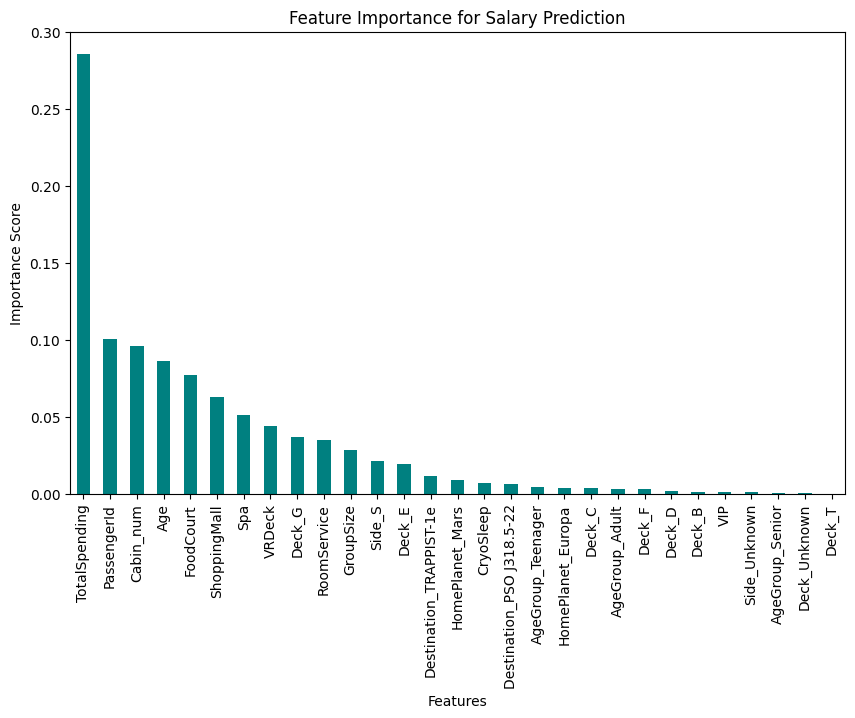

In [25]:
# Check Feature Importance Using a Random Forest Model

dfc_copy = train.copy()
# Prepare data (Remove non-numeric columns)
df_importance = dfc_copy.dropna()

# Define Features (X) and Target (y)
X = df_importance.drop(columns=['Transported'])  # Predicting Salary (TotalPay)
y = df_importance['Transported']

# Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get Feature Importance Scores
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot Feature Importance
feature_importance.plot(kind='bar', figsize=(10,6), color='teal')
plt.title("Feature Importance for Salary Prediction")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

# **STEP 7: Modeling**

In [27]:
# Splitting Data into Training, Validation, and Test Sets

# Define Features (X) and Target (y)
X = train.drop(columns=['Transported','PassengerId'])  
y = train['Transported']  
print(X.shape, y.shape)

(8693, 28) (8693,)


In [28]:
# Split into Train (70%), Validation (15%), and Test (15%)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6954, 28) (1739, 28) (6954,) (1739,)


In [33]:
# matching test columns with train set
test = test.reindex(columns=train.drop(['Transported','PassengerId'], axis=1).columns, fill_value=0)
test.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num', 'TotalSpending', 'GroupSize', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Side_S', 'Side_Unknown', 'AgeGroup_Teenager', 'AgeGroup_Adult', 'AgeGroup_Senior'], dtype='object')

In [34]:
# to avoid data leakage and ensure that our model generalizes well.
scaler = MinMaxScaler()
# computing the mean and std only from the training set, avoiding data leakage.
X_train_scaled = scaler.fit_transform(X_train)  # ✅ Fit on training data
X_val_scaled  = scaler.transform(X_val) # ✅ Transform validation (unseen) data
X_test_scaled = scaler.transform(test) # ✅ Transform Kaggle test data (also unseen)
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully!")

Scaler saved successfully!


In [36]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=30, max_features="sqrt", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM (Linear Kernel)": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42,verbose=-1)
}

classification_results = []

for name, model in models.items():
    print(f"🔍 Modeling: {name}")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    summary = {
        "Model": name,
        "Accuracy": round(accuracy_score(y_val, y_pred), 4),
        "Precision": round(precision_score(y_val, y_pred, average='macro'), 4),
        "Recall": round(recall_score(y_val, y_pred, average='macro'), 4),
        "F1 Score": round(f1_score(y_val, y_pred, average='macro'), 4),
    }

    classification_results.append(summary)

classification_df = pd.DataFrame(classification_results)
classification_df.sort_values(by="F1 Score", ascending=False)

🔍 Modeling: Logistic Regression
🔍 Modeling: Random Forest
🔍 Modeling: Decision Tree
🔍 Modeling: Gradient Boosting
🔍 Modeling: AdaBoost
🔍 Modeling: SVM (Linear Kernel)
🔍 Modeling: KNN
🔍 Modeling: XGBoost
🔍 Modeling: LightGBM


,Model,Accuracy,Precision,Recall,F1 Score
7,XGBoost,0.8194,0.8196,0.8195,0.8194
8,LightGBM,0.8102,0.8103,0.8102,0.8102
1,Random Forest,0.8033,0.8047,0.8036,0.8032
3,Gradient Boosting,0.7993,0.7994,0.7992,0.7993
4,AdaBoost,0.7964,0.7978,0.7962,0.7961
5,SVM (Linear Kernel),0.7648,0.7690,0.7653,0.7641
0,Logistic Regression,0.7625,0.7659,0.7629,0.7619
6,KNN,0.7608,0.7631,0.7611,0.7604
2,Decision Tree,0.7481,0.7481,0.7481,0.7481


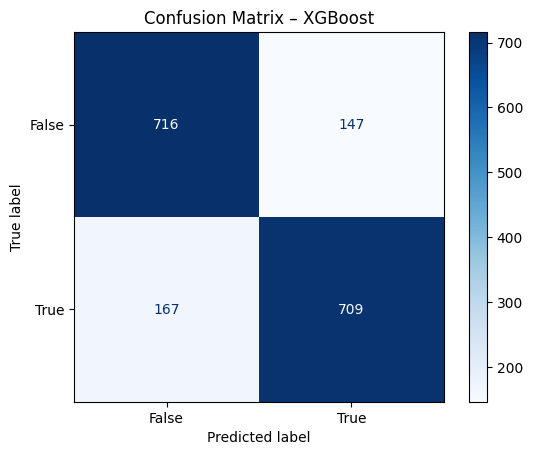


Classification Report for XGBoost
              precision    recall  f1-score   support

       False       0.81      0.83      0.82       863
        True       0.83      0.81      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739



In [37]:
# Find the best model based on F1 Score
best_model_name = classification_df.sort_values(by="F1 Score", ascending=False).iloc[0]['Model']
best_model = models[best_model_name]

# Make predictions
y_pred = best_model.predict(X_val_scaled)

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# Print classification report
print(f"\nClassification Report for {best_model_name}")
print(classification_report(y_val, y_pred))

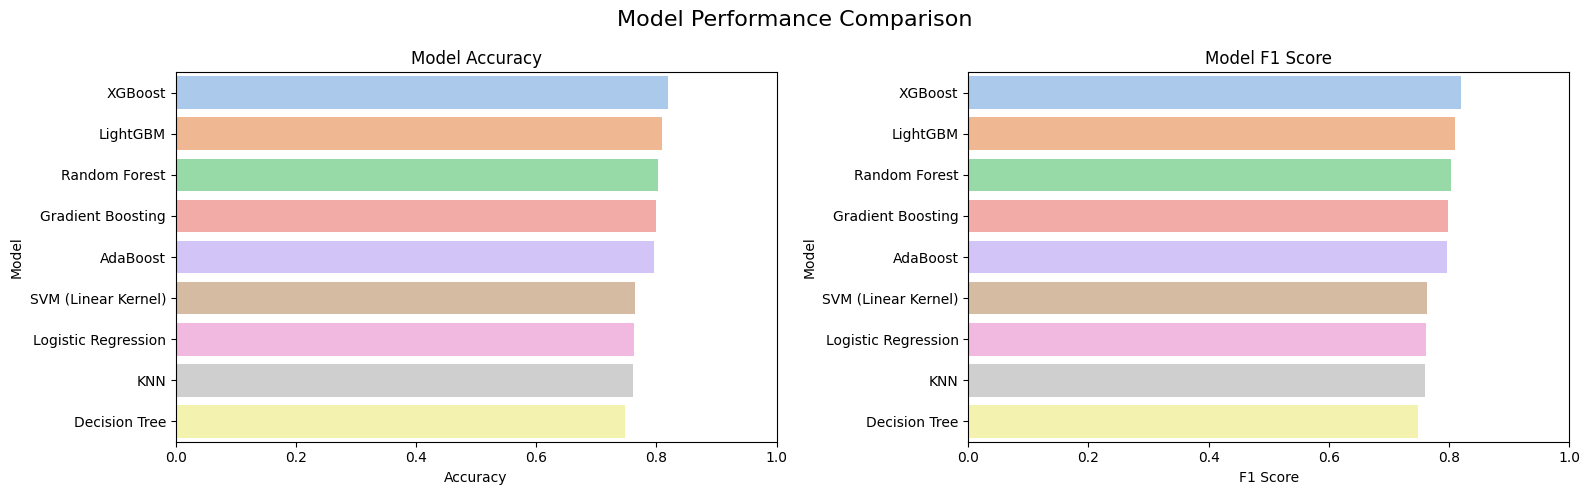

In [39]:
# Sort by F1 Score (or Accuracy if you want)
classification_df_sorted = classification_df.sort_values(by="F1 Score", ascending=False)  # Ascending so best model is at top (barplot is horizontal)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy plot
sns.barplot(
    y='Model', x='Accuracy',
    data=classification_df_sorted,
    order=classification_df_sorted['Model'],
    palette='pastel',
    ax=axes[0]
)
axes[0].set_title("Model Accuracy")
axes[0].set_xlim(0, 1)

# F1 Score plot
sns.barplot(
    y='Model', x='F1 Score',
    data=classification_df_sorted,
    order=classification_df_sorted['Model'],
    palette='pastel',
    ax=axes[1]
)
axes[1].set_title("Model F1 Score")
axes[1].set_xlim(0, 1)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout()
plt.show()


# **STEP 8: Model Evaluation**

In [40]:
# Define models and their hyperparameter grids
models_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=9),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs'],
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7],
        }
    },
    'SVM (Linear/RBF)': {
        'model': SVC(probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 4],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 4],
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, verbose=-1),
        'param_grid': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50],
        }
    }
}

# Train and evaluate models
# Train and evaluate models
summary_list = []
best_estimators = {}

for name, model_info in models_grid.items():
    print(f"🔍 Tuning: {name}")
    model = model_info['model']
    param_grid = model_info['param_grid']
    # for faster convergence and run (due to the large dataset)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val_scaled)
    
    cross_val = cross_val_score(grid_search.best_estimator_, X_train_scaled,y_train,cv=5)
    print(f"Mean cross-validation score: {cross_val.mean():.4f}")
    
    summary_list.append({
        "Model": name,
        "Best Params": grid_search.best_params_,
        "Accuracy": round(accuracy_score(y_val, y_pred), 4),
        "Precision": round(precision_score(y_val, y_pred, average='macro'), 4),
        "Recall": round(recall_score(y_val, y_pred, average='macro'), 4),
        "F1 Score": round(f1_score(y_val, y_pred, average='macro'), 4),
        "CV Score": round(cross_val.mean(), 4)
    })

    best_estimators[name] = best_model

# Create DataFrame and display
summary_df = pd.DataFrame(summary_list).sort_values(by='Accuracy', ascending=False)
summary_df

🔍 Tuning: Logistic Regression
Mean cross-validation score: 0.7928
🔍 Tuning: KNN
Mean cross-validation score: 0.7412
🔍 Tuning: SVM (Linear/RBF)
Mean cross-validation score: 0.7866
🔍 Tuning: Decision Tree
Mean cross-validation score: 0.7719
🔍 Tuning: Random Forest
Mean cross-validation score: 0.8013
🔍 Tuning: Gradient Boosting
Mean cross-validation score: 0.8054
🔍 Tuning: XGBoost
Mean cross-validation score: 0.8050
🔍 Tuning: AdaBoost
Mean cross-validation score: 0.7752
🔍 Tuning: LightGBM
Mean cross-validation score: 0.8062


,Model,Best Params,Accuracy,Precision,Recall,F1 Score,CV Score
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.8125,0.8126,0.8125,0.8125,0.8050
8,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.8102,0.8103,0.8102,0.8102,0.8062
5,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.7993,0.7994,0.7992,0.7993,0.8054
4,Random Forest,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.7936,0.7936,0.7936,0.7936,0.8013
0,Logistic Regression,"{'C': 100, 'solver': 'liblinear'}",0.7907,0.7908,0.7906,0.7906,0.7928
3,Decision Tree,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.7884,0.7884,0.7884,0.7884,0.7719
7,AdaBoost,"{'learning_rate': 0.1, 'n_estimators': 100}",0.7746,0.7763,0.7749,0.7743,0.7752
2,SVM (Linear/RBF),"{'C': 10, 'kernel': 'linear'}",0.7740,0.7757,0.7743,0.7738,0.7866
1,KNN,{'n_neighbors': 7},0.7591,0.7620,0.7594,0.7585,0.7412


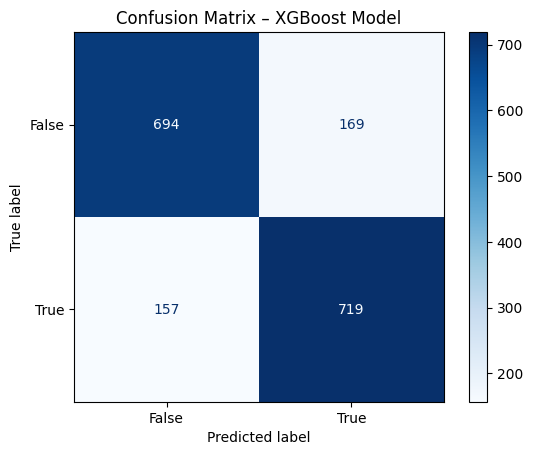

Classification Report – XGBoost Model
              precision    recall  f1-score   support

       False       0.82      0.80      0.81       863
        True       0.81      0.82      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [41]:
# Choose based on summary_df or your evaluation results
best_model_name = summary_df.sort_values(by='F1 Score',ascending=False).iloc[0]['Model']
best_model = best_estimators[best_model_name]

# Evaluate
y_pred = best_model.predict(X_val_scaled)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val, cmap='Blues')
plt.title(f"Confusion Matrix – {best_model_name} Model")
plt.show()

# Classification Report
print(f"Classification Report – {best_model_name} Model")
print(classification_report(y_val, y_pred))

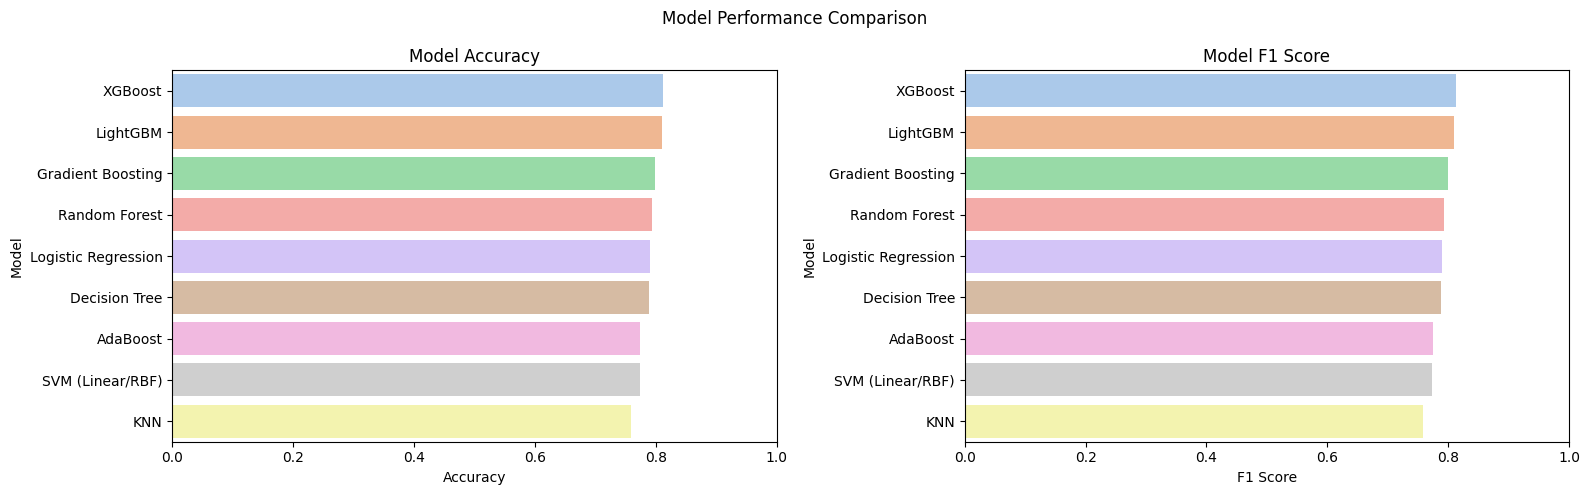

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(y=summary_df['Model'], x=summary_df['Accuracy'], palette='pastel', ax=axes[0])
axes[0].set_title("Model Accuracy")
axes[0].set_xlim(0, 1)

sns.barplot(y=summary_df['Model'], x=summary_df['F1 Score'], palette='pastel', ax=axes[1])
axes[1].set_title("Model F1 Score")
axes[1].set_xlim(0, 1)

plt.suptitle("Model Performance Comparison")
plt.tight_layout()
plt.show()

# **Step 9: Deployment & Submission**

In [59]:
# combine train and validation sets
X_full = pd.concat([X_train,X_val])
y_full = pd.concat([y_train, y_val])

# refit scaler on full data
final_scaler = MinMaxScaler()
X_full_scaled = final_scaler.fit_transform(X_full)
X_test_scaled = final_scaler.transform(test)

# Load best tuned model
sorted_pre_tuned_model = classification_df.sort_values(by='Accuracy',ascending=False)
best_model_name = sorted_pre_tuned_model.iloc[0]['Model']
best_model = best_estimators[best_model_name]

# Retrain best model on full data
final_model = best_model.__class__(**best_model.get_params())  # copy tuned parameters
final_model = best_model.fit(X_full_scaled, y_full)

# Predict on test set
test_predictions = final_model.predict(X_test_scaled)

if test_predictions.dtype != bool:
    test_predictions = pd.Series(test_predictions).map({1: True, 0: False}).values

# Prepare submission file
submission = pd.read_csv("C:/Users/ARZ/Desktop/sample_submission.csv")
submission["Transported"] = test_predictions
submission.to_csv("submission.csv", index=False)

# Save final model and scaler
joblib.dump(final_model, "final_model.pkl")
joblib.dump(final_scaler, "final_scaler.pkl")

print(f"✅ Submission file saved as submission.csv")
print(f"✅ Final model saved as final_model.pkl")
print(f"✅ Final scaler saved as final_scaler.pkl")

✅ Submission file saved as submission.csv
✅ Final model saved as final_model.pkl
✅ Final scaler saved as final_scaler.pkl
